In [1]:
import numpy as np  
import pandas as pd  


In [2]:
target = np.array(np.load('genome/target', allow_pickle=True)) - 1
mmap_array = np.load('all_chromosomes/all_chromosomes.npy', mmap_mode='r')
snp_list = np.load('genome/combined_SNP', allow_pickle=True)

In [3]:
df = pd.DataFrame(mmap_array, columns=[snp_list[i] for i in range(len(snp_list))])
df['target'] = target
df

,rs3094315_G,rs3131972_A,rs3131969_A,rs1048488_G,rs12562034_A,rs12124819_G,rs2980300_A,rs11240777_A,rs4970383_A,rs4475691_A,...,rs9628187_A,rs6010063_G,rs10451_A,rs715586_A,rs2301584_A,rs756638_A,rs3810648_G,rs2285395_A,rs3888396_G,target
0,1,1,1,1,0,0,1,1,2,2,...,1,0,0,0,0,1,0,0,0,1
1,1,1,1,1,0,0,1,1,0,0,...,0,1,1,0,0,1,2,2,0,1
2,1,1,0,1,0,1,0,0,0,0,...,1,1,0,1,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,1,1,...,0,1,0,1,0,0,0,0,0,1
4,1,1,1,1,0,1,1,1,0,0,...,1,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5556,0,0,0,0,0,0,1,1,1,1,...,2,0,0,0,0,0,0,0,1,1
5557,0,0,0,0,0,2,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1
5558,1,1,0,1,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,1,1
5559,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1


In [4]:
from scipy.stats import chi2_contingency
from concurrent.futures import ProcessPoolExecutor, as_completed

from tqdm import tqdm

In [5]:
def chi_squared_test(snp):
    try:
        crosstab = pd.crosstab(df[snp], df['target'])
        if np.all(crosstab.sum(axis=1) > 0):
            chi2, p, dof, ex = chi2_contingency(crosstab)
            if p < 0.05:
                return snp, p
        return snp, np.nan
    except Exception as e:
        print(f"Error processing SNP {snp}: {e}")
        return snp, np.nan

In [6]:
results = []
snps = df.columns[:-1]   

with ProcessPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(chi_squared_test, snp): snp for snp in snps}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing SNPs"):
        results.append(future.result())

Processing SNPs: 100%|██████████| 883908/883908 [41:34<00:00, 354.28it/s]


In [7]:
results_df = pd.DataFrame(results, columns=['SNP', 'p-value'])

In [9]:
results_df.to_csv('/kaggle/working/chi_squared_test_results.csv', index=False)
results_df

,SNP,p-value
0,rs4655134_C,NaN
1,rs12741018_G,NaN
2,rs17407901_A,0.017873
3,rs6670405_G,NaN
4,rs3789541_A,NaN
...,...,...
883903,rs10451_A,NaN
883904,rs2040487_G,NaN
883905,rs756638_A,NaN
883906,rs2301584_A,NaN


In [14]:
significant_snps = results_df[results_df['p-value'] < 0.05]
significant_snps_list = significant_snps['SNP'].tolist()
len(significant_snps_list)

92398

In [15]:
significant_snps.to_csv('significant_snps.csv', index=False)

In [4]:
significant_snps['-log10(p-value)'] = -np.log10(significant_snps['p-value'])


In [2]:
significant_snps = pd.read_csv('significant_snps.csv')

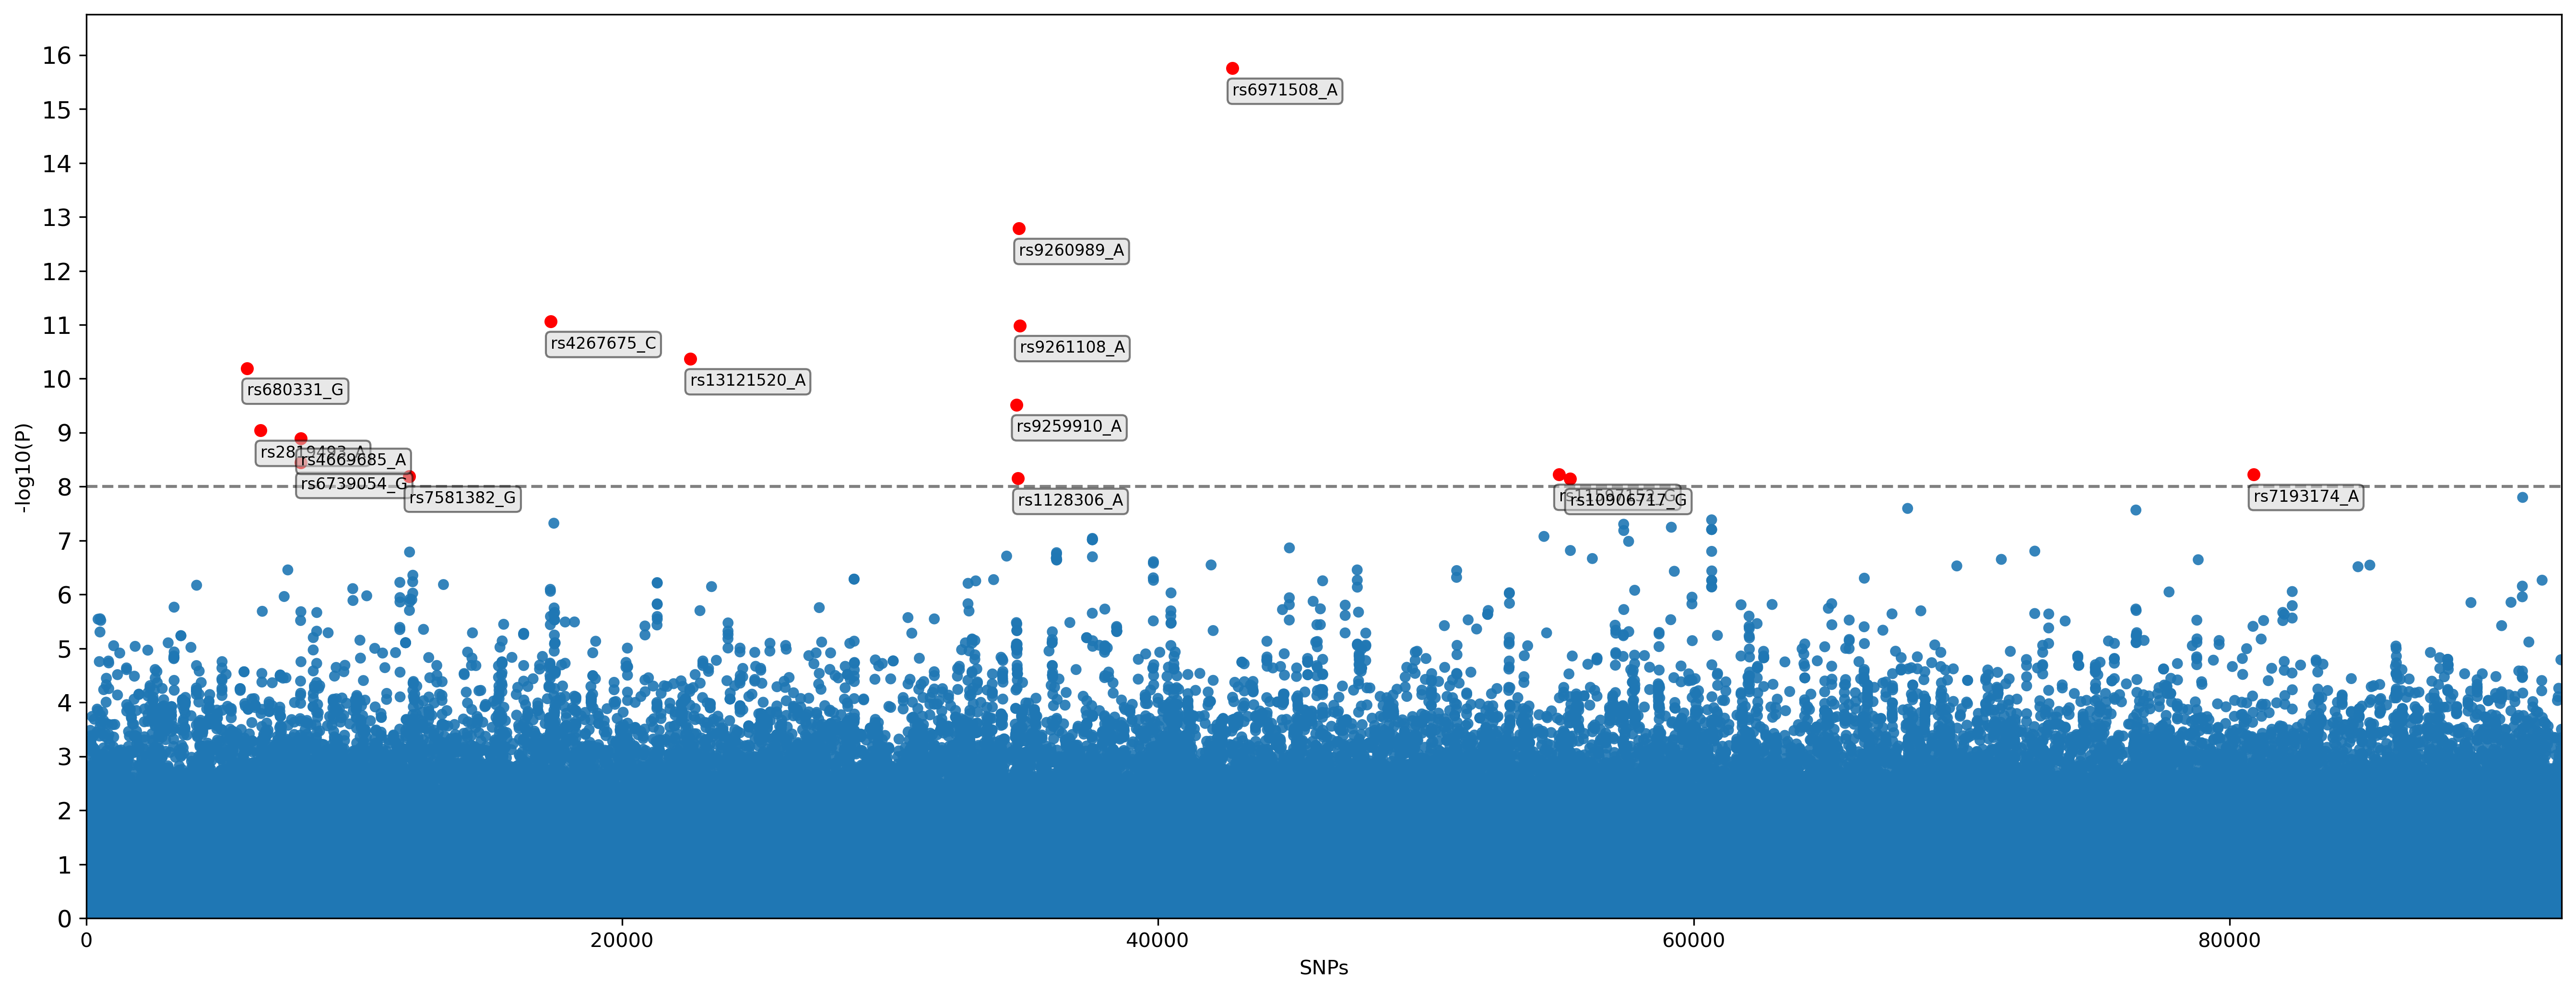

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 7),dpi=300)
scatter = sns.scatterplot(
    x=significant_snps.index,
    y=significant_snps['-log10(p-value)'],
    s=30,
    edgecolor='none',
    alpha=0.9
)

significant_points = significant_snps[significant_snps['-log10(p-value)'] > 8]
plt.scatter(significant_points.index, significant_points['-log10(p-value)'], color='red', s=30)

for i in range(len(significant_snps)):
    if significant_snps['-log10(p-value)'].iloc[i] > 8:
        plt.text(significant_snps.index[i]+1, 
                 significant_snps['-log10(p-value)'].iloc[i]-0.5, 
                 significant_snps['SNP'].iloc[i], 
                 fontsize=8, 
                 ha='left',
                 bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.3'))

ylim_min = significant_snps['-log10(p-value)'].min()
fill_x = np.random.choice(significant_snps.index, 5000)   
fill_y = np.random.uniform(0, ylim_min, 5000)   
plt.scatter(fill_x, fill_y, color=sns.color_palette()[0], s=400, edgecolor='none')

plt.xlabel('SNPs')
plt.ylabel('-log10(P)')

plt.axhline(y=8, color='grey', linestyle='--')

plt.xlim(0, significant_snps.index.max())
plt.ylim(0, significant_snps['-log10(p-value)'].max() + 1)
plt.yticks(range(17),fontsize=12)

plt.tight_layout()
plt.grid(False)
plt.show()

In [91]:
sorted_snps = significant_snps.sort_values(by='-log10(p-value)', ascending=False)

sorted_snps.to_csv('sorted_significant_snps.csv', index=False)

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
results = {}

for num in tqdm(range(1000, 51000, 1000), desc="Processing SNPs"):
    top_snps = sorted_snps['SNP'].head(num)
    X = df[top_snps]
    y = np.array(target)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    f1_scores_class0 = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        f1_class0 = f1_score(y_test, y_pred, pos_label=0)   
        f1_scores_class0.append(f1_class0)
    
    avg_f1_class0 = np.mean(f1_scores_class0)
    results[num] = {
        'fold_scores': f1_scores_class0,
        'average_score': avg_f1_class0
    }

for num, scores in results.items():
    print(f"Number of SNPs: {num}")
    print(f"Class 0 F1 scores for each fold: {scores['fold_scores']}")
    print(f"Average Class 0 F1 score: {scores['average_score']}\n")

Processing SNPs: 100%|██████████| 50/50 [2:23:31<00:00, 172.22s/it]  

Number of SNPs: 1000
Class 0 F1 scores for each fold: [0.5185185185185186, 0.47430830039525695, 0.5190839694656489, 0.4744525547445256, 0.5223880597014926]
Average Class 0 F1 score: 0.5017502805650885

Number of SNPs: 2000
Class 0 F1 scores for each fold: [0.6823529411764705, 0.5506072874493927, 0.5606060606060606, 0.5230769230769231, 0.5952380952380951]
Average Class 0 F1 score: 0.5823762615093884

Number of SNPs: 3000
Class 0 F1 scores for each fold: [0.631578947368421, 0.6194690265486725, 0.6224066390041493, 0.5872340425531914, 0.6584362139917695]
Average Class 0 F1 score: 0.6238249738932408

Number of SNPs: 4000
Class 0 F1 scores for each fold: [0.6748971193415638, 0.6491228070175439, 0.6723404255319148, 0.6120689655172412, 0.6306306306306305]
Average Class 0 F1 score: 0.6478119896077789

Number of SNPs: 5000
Class 0 F1 scores for each fold: [0.6416666666666667, 0.6260869565217392, 0.646551724137931, 0.6017699115044248, 0.6636771300448431]
Average Class 0 F1 score: 0.63595047777512

In [108]:
num_snps = sorted(results.keys())
fold_scores = [results[num]['fold_scores'] for num in num_snps]
average_scores = [results[num]['average_score'] for num in num_snps]

fold_scores_transposed = list(zip(*fold_scores))

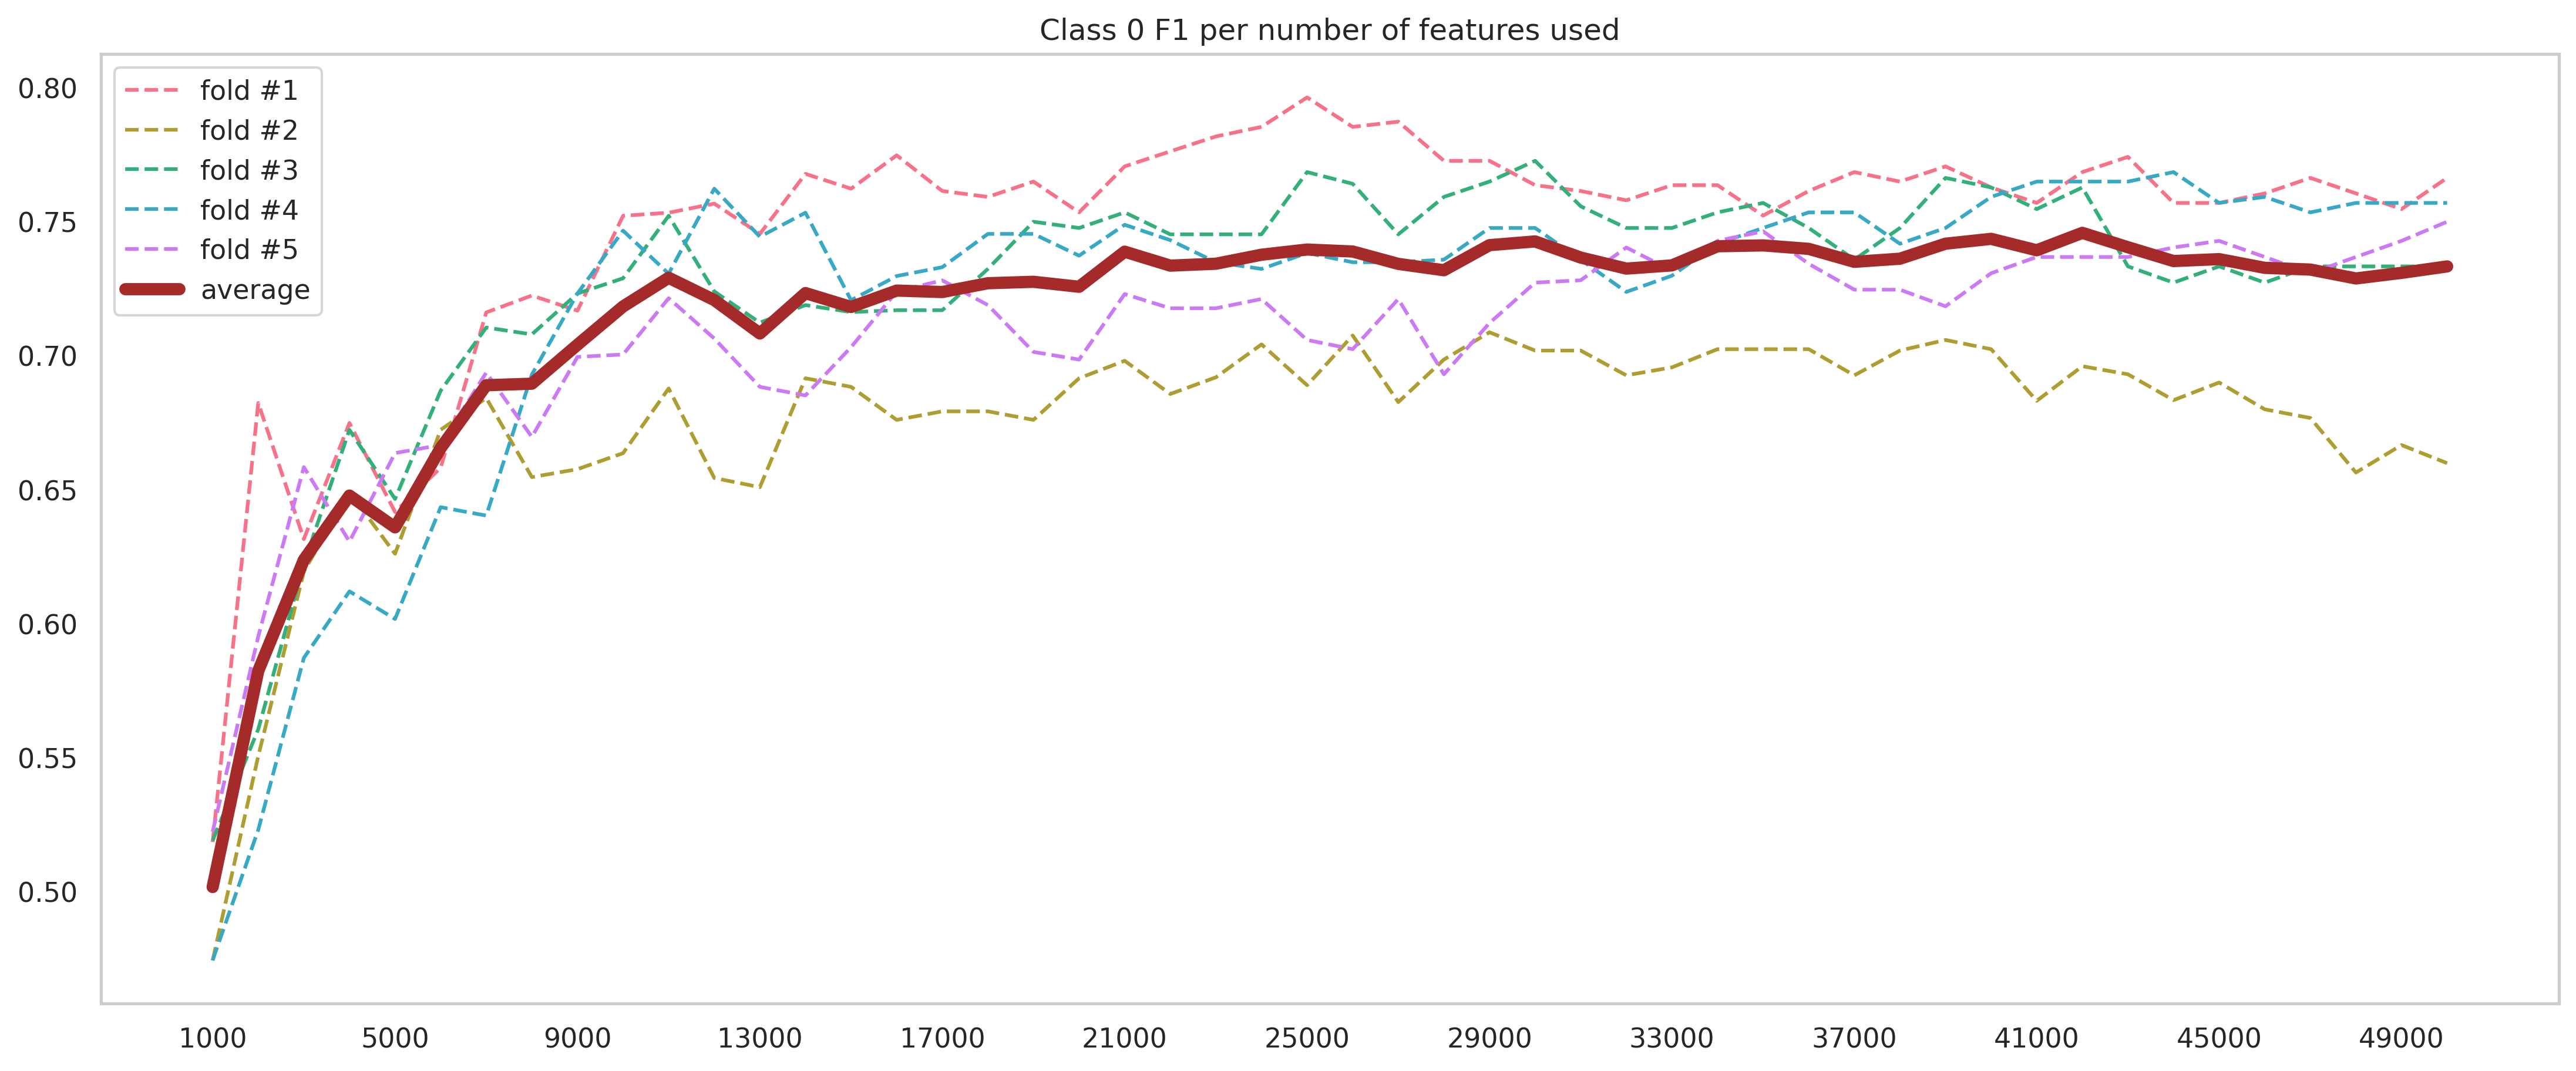

In [118]:
plt.figure(figsize=(18, 7),dpi=300)
palette = sns.color_palette("husl", len(fold_scores_transposed))
for i, (fold_scores, color) in enumerate(zip(fold_scores_transposed, palette), start=1):
    plt.plot(num_snps, fold_scores, linestyle='--', color=color, label=f'fold #{i}')

plt.plot(num_snps, average_scores, color='brown', linewidth=5, label='average')
plt.xticks(np.arange(1000, max(num_snps) + 1, 4000))
plt.legend()
plt.title('Class 0 F1 per number of features used')
plt.grid(False)
plt.show()


In [123]:
top_snps = sorted_snps['SNP'].head(30000)
top_snps.to_csv('first_30000_snps.csv', index=False)